In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('daily-website-visitors.csv', thousands=',')

In [3]:
df.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,2146,1582,1430,152
1,2,Monday,2,9/15/2014,3621,2528,2297,231
2,3,Tuesday,3,9/16/2014,3698,2630,2352,278
3,4,Wednesday,4,9/17/2014,3667,2614,2327,287
4,5,Thursday,5,9/18/2014,3316,2366,2130,236


In [4]:
pd.to_datetime(df["Date"]).min()

Timestamp('2014-09-14 00:00:00')

In [5]:
pd.to_datetime(df["Date"]).max()

Timestamp('2020-08-19 00:00:00')

In [6]:
# Contar valores nulos
print(df.isnull().sum())

Row                  0
Day                  0
Day.Of.Week          0
Date                 0
Page.Loads           0
Unique.Visits        0
First.Time.Visits    0
Returning.Visits     0
dtype: int64


In [7]:
df['Date'] = pd.to_datetime(df['Date']).dropna()

El modelo tiene un comportamiento no estacionario ya que tiene una tendencia creciente a lo largo del tiempo. Para solucionar esto, se puede aplicar una transformación logarítmica a los datos.

(2167, 1)

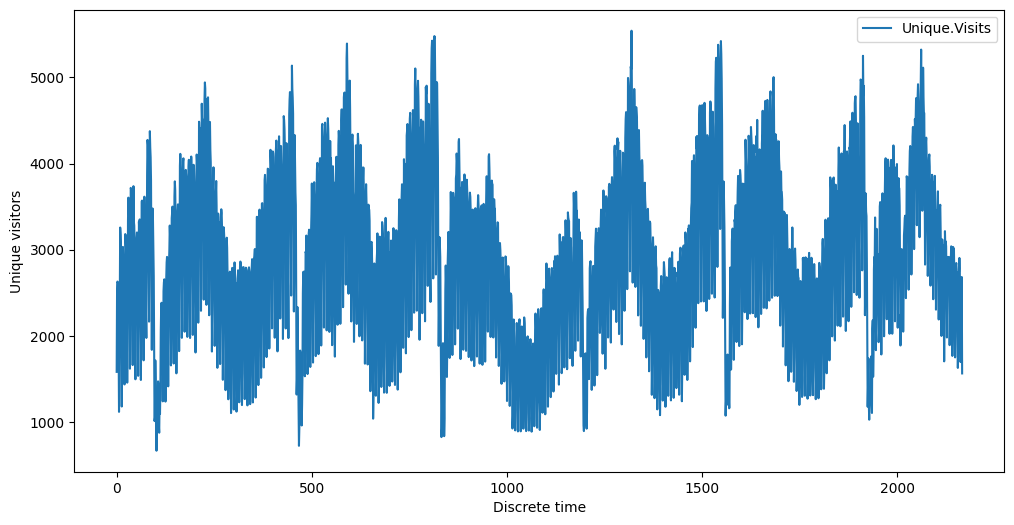

In [8]:
series = pd.DataFrame(data=df['Unique.Visits'], columns = ['Unique.Visits']).dropna()
series.plot(figsize=(12, 6))
plt.ylabel('Unique visitors')
plt.xlabel('Discrete time')
series.shape

Al realizar una prueba formal de estacionariedad (Dickey-Fuller aumentada), se obtiene un p-valor de 0.9989, lo que indica que no se puede rechazar la hipótesis nula de que los datos no son estacionarios.

In [9]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Se asegura que la columna Date sea el índice y esté en formato datetime
df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)

# Se realiza la prueba ADF sobre la columna Gold_Price
result = adfuller(df['Unique.Visits'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -4.4759685744454085
p-value: 0.0002172640930007976
Critical Values 1%: -3.4334094211542983
Critical Values 5%: -2.8628915360971003
Critical Values 10%: -2.5674894918770197


Se aplica una diferenciación en los datos para eliminar la tendencia

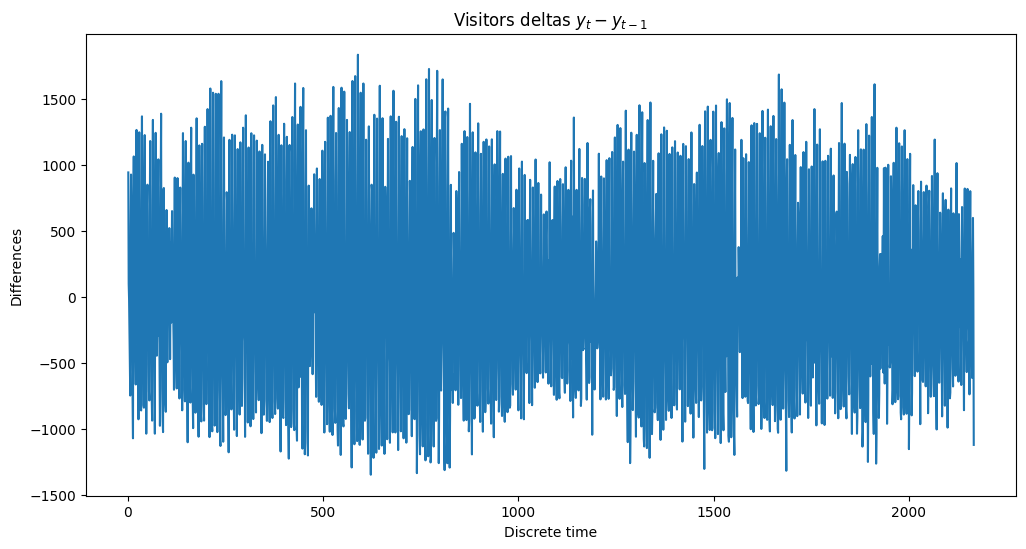

In [10]:
# Se aplica una diferenciación para eliminar la tendencia
df['visitors_diff'] = df['Unique.Visits'].diff().dropna()
# Se grafica la serie diferenciada
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(df.index, df['visitors_diff'], label='visitors_diff')
plt.title('Visitors deltas $y_t - y_{t-1}$')
plt.ylabel('Differences')
plt.xlabel('Discrete time')
plt.show()

Al probar la estacionariedad de los datos diferenciados, se obtiene un p-valor de 1.72e-21, lo que indica que se puede rechazar la hipótesis nula de que los datos no son estacionarios.

In [11]:
# Prueba ADF en la serie diferenciada
result_diff = adfuller(df['visitors_diff'].dropna())
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])
for key, value in result_diff[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -12.129598735255767
p-value: 1.7482961408023245e-22
Critical Values 1%: -3.4334108531807006
Critical Values 5%: -2.862892168387536
Critical Values 10%: -2.5674898285322496


AR(1): R² ajustado = 0.5861877566954458, Error Promedio (MSE) = 612.9875781808777, Error absoluto  (MAE) = 494.6027931559118
AR(1): coeficientes = [0.74960527], intercepto = 718.4729783506978
AR(2): R² ajustado = 0.6668006700551111, Error Promedio (MSE) = 549.9225869470084, Error absoluto  (MAE) = 454.4710720627479
AR(2): coeficientes = [ 1.12012601 -0.49458535], intercepto = 1073.7311560982005
AR(3): R² ajustado = 0.718171944801425, Error Promedio (MSE) = 505.63957261483415, Error absoluto  (MAE) = 427.78636747175847
AR(3): coeficientes = [ 1.30214094 -0.90693322  0.36835047], intercepto = 678.3483431798436
AR(4): R² ajustado = 0.7175373579071463, Error Promedio (MSE) = 506.09127629562244, Error absoluto  (MAE) = 426.469756818812
AR(4): coeficientes = [ 1.32242966 -0.95689269  0.44003411 -0.05507501], intercepto = 715.6846971247764


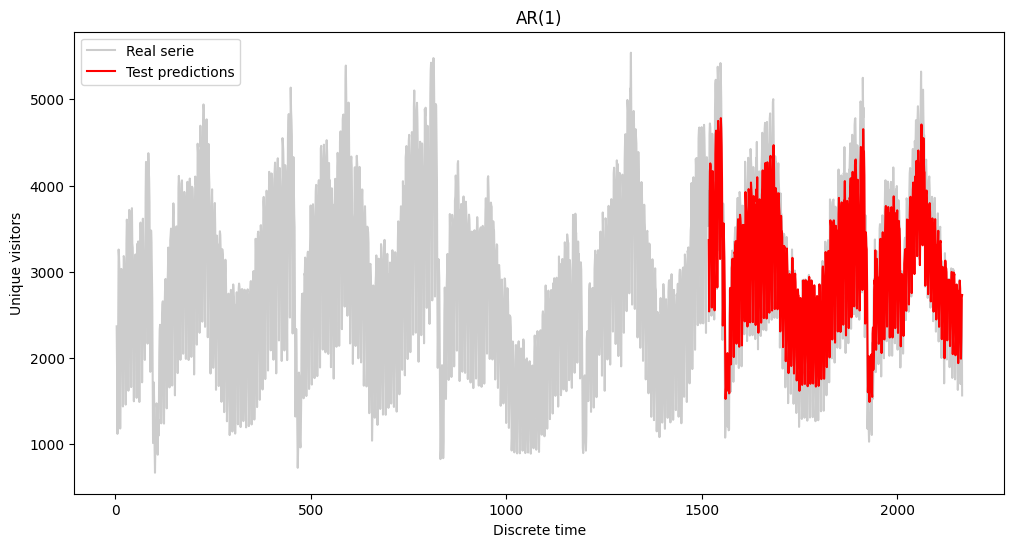

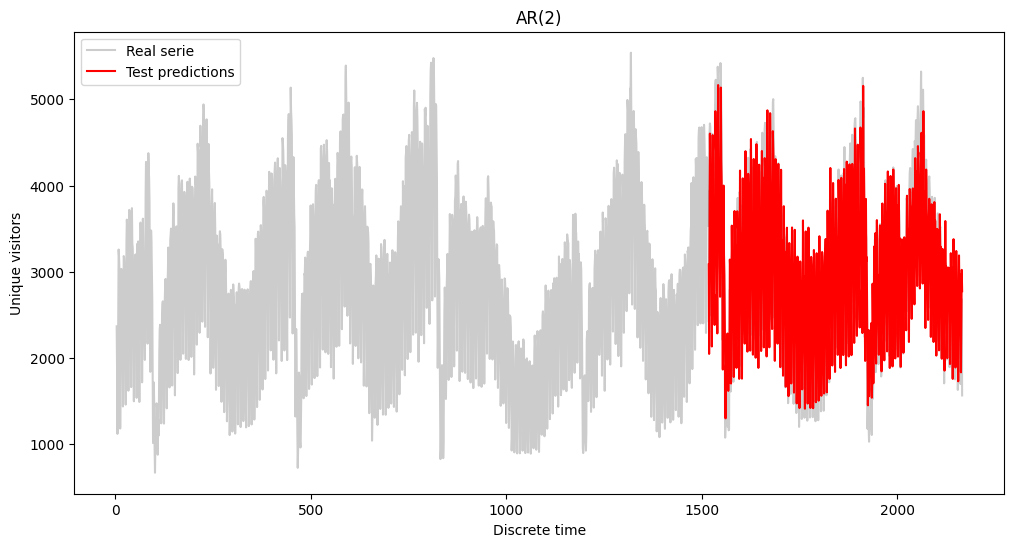

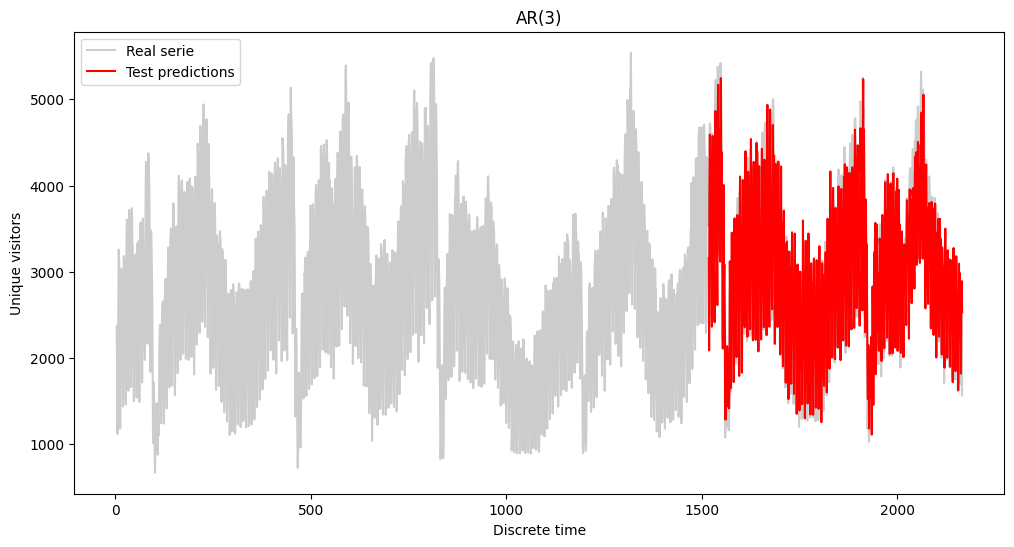

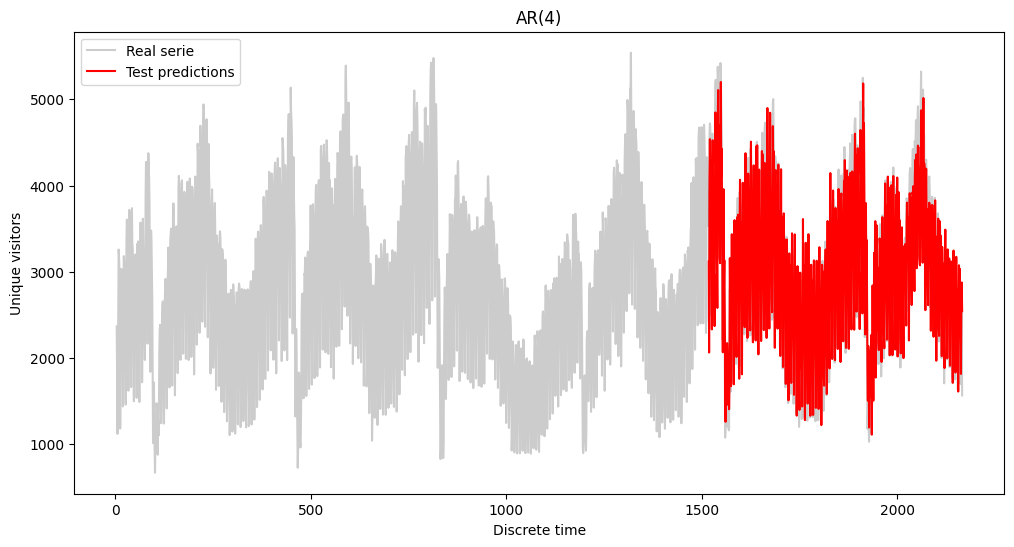

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split
# Se crean las variables lag (rezagadas) para AR(1) a AR(4)
for lag in range(1, 5):
    df[f'lag_{lag}'] = df['Unique.Visits'].shift(lag)
# Se eliminan los valores NaN generados por las lags
df.dropna(inplace=True)
# Se configura el modelo de regresión para cada AR(p)
X = df[[f'lag_{i}' for i in range(1, 5)]]
y = df['Unique.Visits']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
models = {}
for lag in range(1, 5):
    X_lag = X.iloc[:, :lag]
    X_lag_train = X_train.iloc[:, :lag]
    X_lag_test = X_test.iloc[:, :lag]
    model = LinearRegression()
    model.fit(X_lag_train, y_train)
    models[f'AR({lag})'] = model
    predictions = model.predict(X_lag_test)
    predictions = pd.Series(predictions)
    predictions.index = y_test.index
    # Se evalúa el modelo
    r2_adj = 1 - (1 - r2_score(y_test, predictions)) * (len(y) - 1) / (len(y) - X_lag.shape[1] - 1)
    mse = root_mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    print(f'AR({lag}): R² ajustado = {r2_adj}, Error Promedio (MSE) = {mse}, Error absoluto  (MAE) = {mae}')
    print(f'AR({lag}): coeficientes = {model.coef_}, intercepto = {model.intercept_}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_train, color = 'black', alpha = 0.2, label = "Real serie")
    plt.plot(y_test, color = 'black', alpha = 0.2)
    plt.plot(predictions, color = 'red', alpha = 1, label = "Test predictions")

    plt.ylabel('Unique visitors')
    plt.xlabel('Discrete time')
    plt.title(f"AR({lag})")
    plt.legend()

AR(1): R² ajustado = 0.08594166450927554, Error Promedio (MSE) = 618.0516552050993, Error absoluto  (MAE) = 517.8311287748883
AR(1): coeficientes = [0.307849], intercepto = 0.018891244429821208
AR(2): R² ajustado = 0.3343796958192662, Error Promedio (MSE) = 527.2910543681655, Error absoluto  (MAE) = 452.75967784316845
AR(2): coeficientes = [ 0.47315559 -0.53902643], intercepto = 0.4949100479610063
AR(3): R² ajustado = 0.33769538471712157, Error Promedio (MSE) = 525.8541098819492, Error absoluto  (MAE) = 451.42363976627496
AR(3): coeficientes = [ 0.44058348 -0.51050433 -0.06037992], intercepto = 0.570578587554302
AR(4): R² ajustado = 0.5536166778527909, Error Promedio (MSE) = 431.6080876597291, Error absoluto  (MAE) = 340.1078396232915
AR(4): coeficientes = [ 0.40162343 -0.83058008  0.21518387 -0.62744519], intercepto = 1.4822665879201633


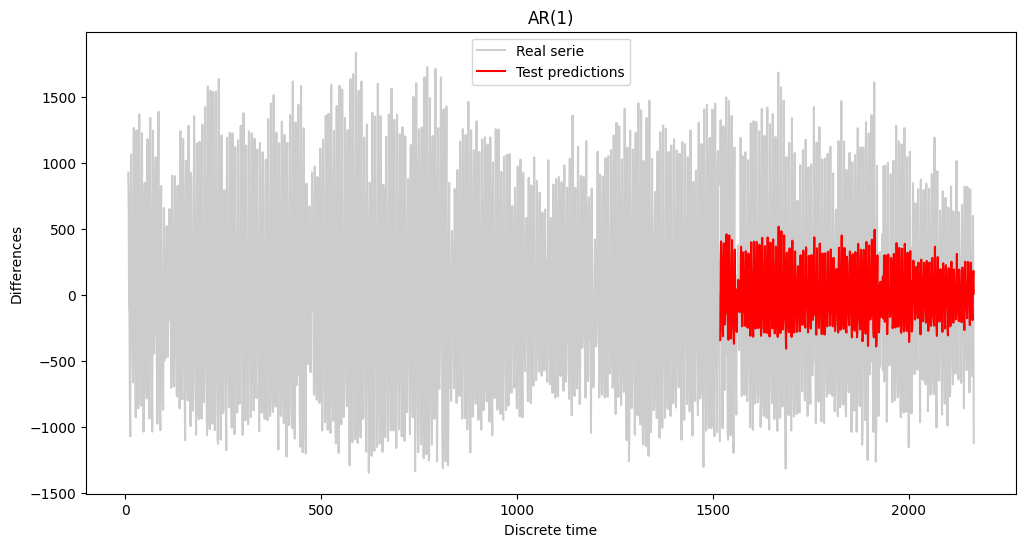

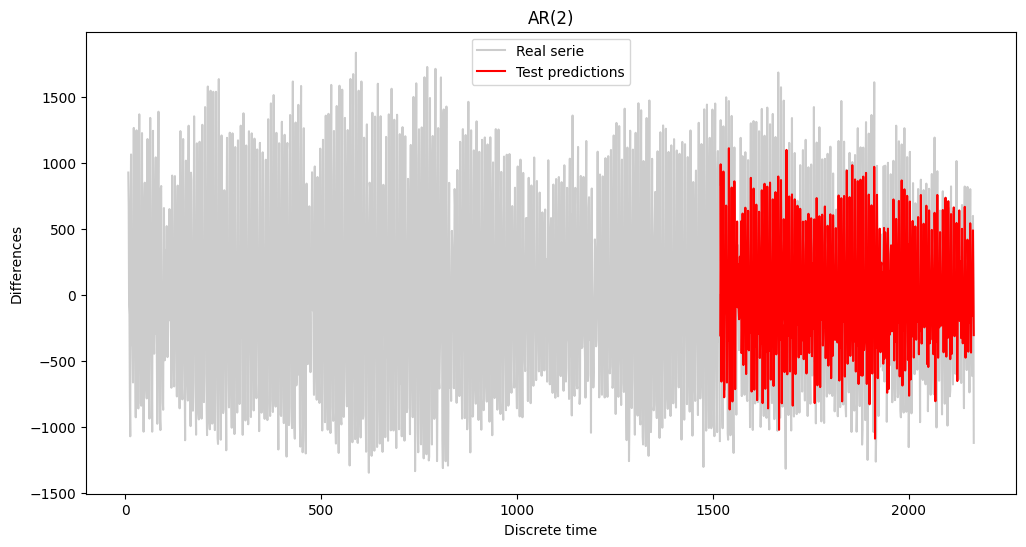

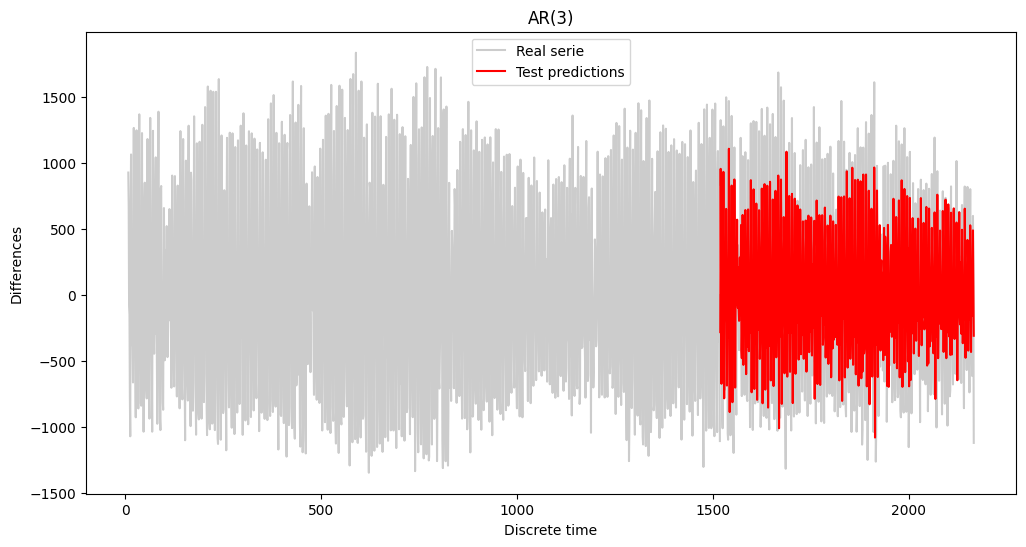

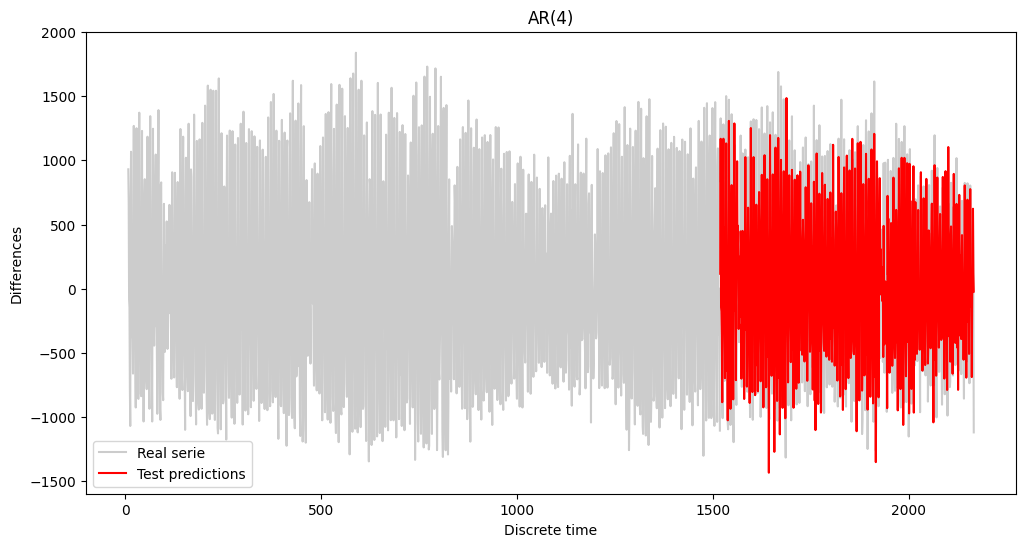

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
# Se crean las variables lag (rezagadas) para AR(1) a AR(4)
for lag in range(1, 5):
    df[f'lag_{lag}'] = df['visitors_diff'].shift(lag)
# Se eliminan los valores NaN generados por las lags
df.dropna(inplace=True)
# Se configura el modelo de regresión para cada AR(p)
X = df[[f'lag_{i}' for i in range(1, 5)]]
y = df['visitors_diff']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
models = {}
for lag in range(1, 5):
    X_lag = X.iloc[:, :lag]
    X_lag_train = X_train.iloc[:, :lag]
    X_lag_test = X_test.iloc[:, :lag]
    model = LinearRegression()
    model.fit(X_lag_train, y_train)
    models[f'AR({lag})'] = model
    predictions = model.predict(X_lag_test)
    predictions = pd.Series(predictions)
    predictions.index = y_test.index
    # Se evalúa el modelo
    r2_adj = 1 - (1 - r2_score(y_test, predictions)) * (len(y) - 1) / (len(y) - X_lag.shape[1] - 1)
    mse = root_mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    print(f'AR({lag}): R² ajustado = {r2_adj}, Error Promedio (MSE) = {mse}, Error absoluto  (MAE) = {mae}')
    print(f'AR({lag}): coeficientes = {model.coef_}, intercepto = {model.intercept_}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_train, color = 'black', alpha = 0.2, label = "Real serie")
    plt.plot(y_test, color = 'black', alpha = 0.2)
    plt.plot(predictions, color = 'red', alpha = 1, label = "Test predictions")
    plt.ylabel('Differences')
    plt.xlabel('Discrete time')
    plt.title(f"AR({lag})")
    plt.legend()

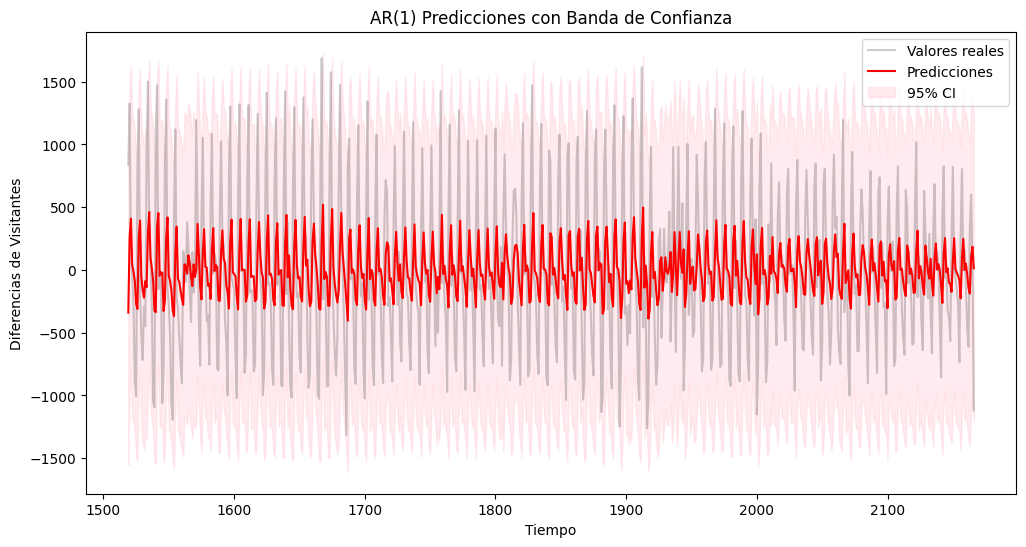

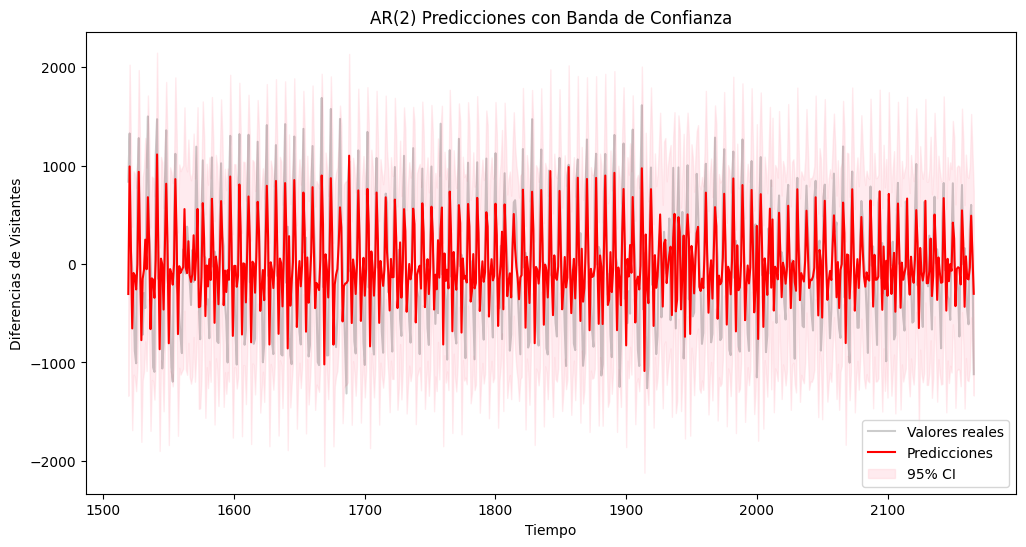

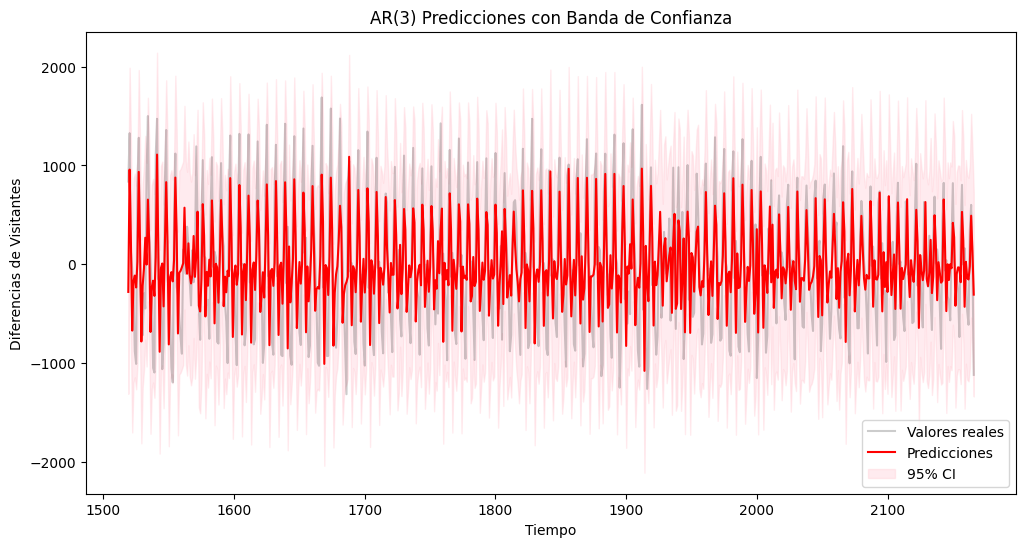

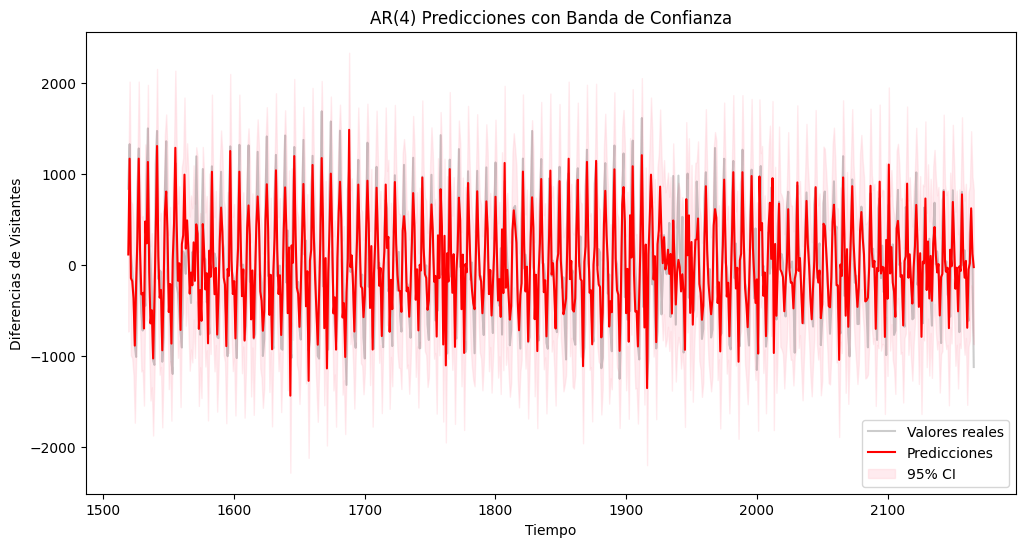

In [15]:
import statsmodels.api as sm
import numpy as np

for lag in range(1, 5):
    X_lag = X.iloc[:, :lag]
    X_lag_train = X_train.iloc[:, :lag]
    X_lag_test = X_test.iloc[:, :lag]
    
    model = LinearRegression()
    model.fit(X_lag_train, y_train)
    models[f'AR({lag})'] = model
    
    predictions = model.predict(X_lag_test)
    predictions = pd.Series(predictions)
    predictions.index = y_test.index
    
    confidence_interval = 1.96 * np.std(predictions - y_test)  #95% 
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, color='black', alpha=0.2, label="Valores reales")
    plt.plot(predictions.index, predictions, color='red', label="Predicciones")
    plt.fill_between(predictions.index, predictions - confidence_interval, predictions + confidence_interval, color='pink', alpha=0.3, label="95% CI")
    
    plt.title(f"AR({lag}) Predicciones con Banda de Confianza")
    plt.xlabel('Tiempo')
    plt.ylabel('Diferencias de Visitantes')
    plt.legend()
    plt.show()


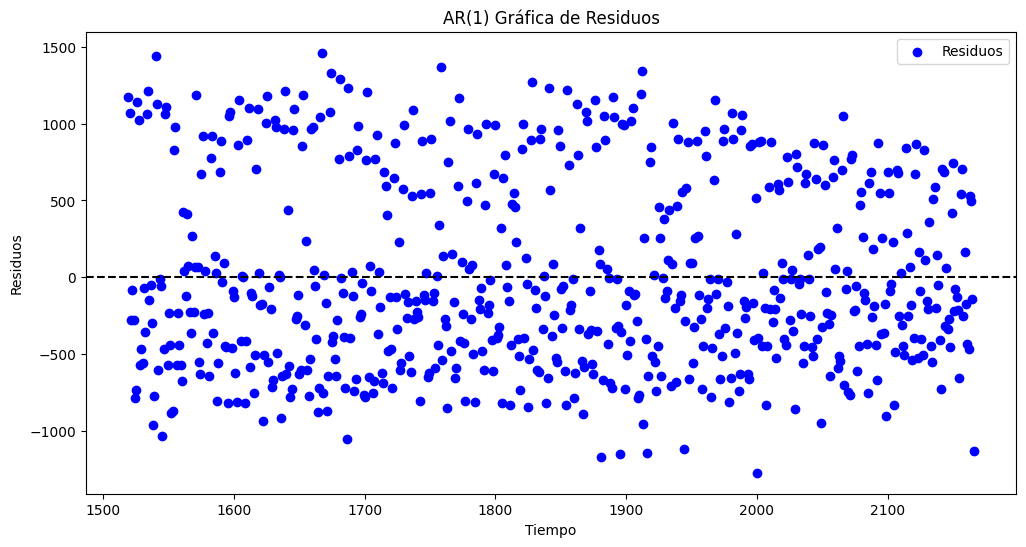

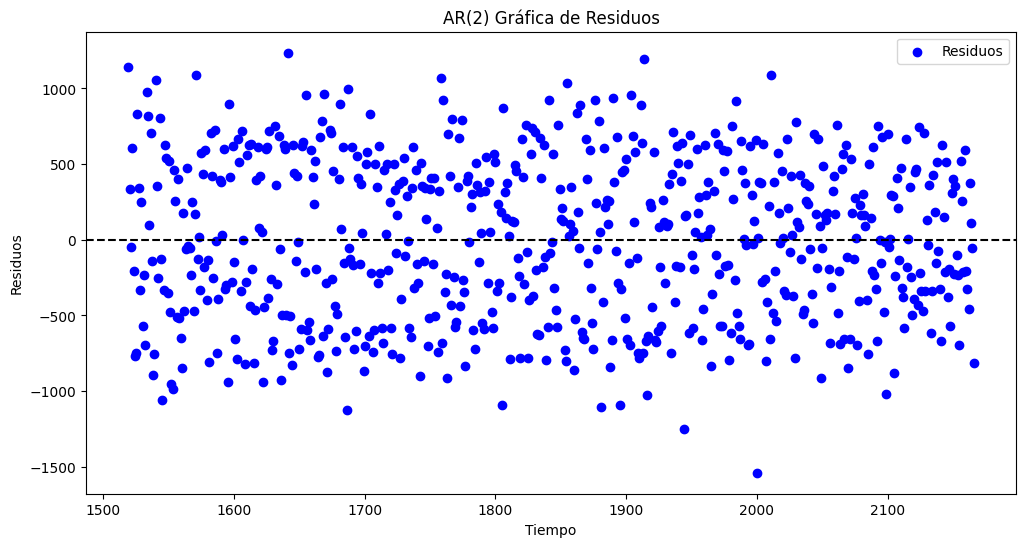

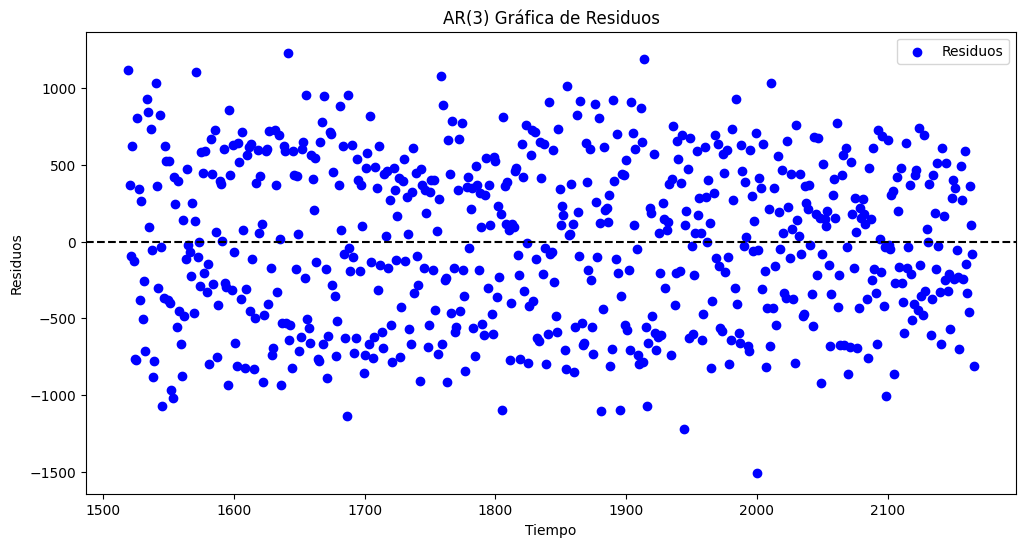

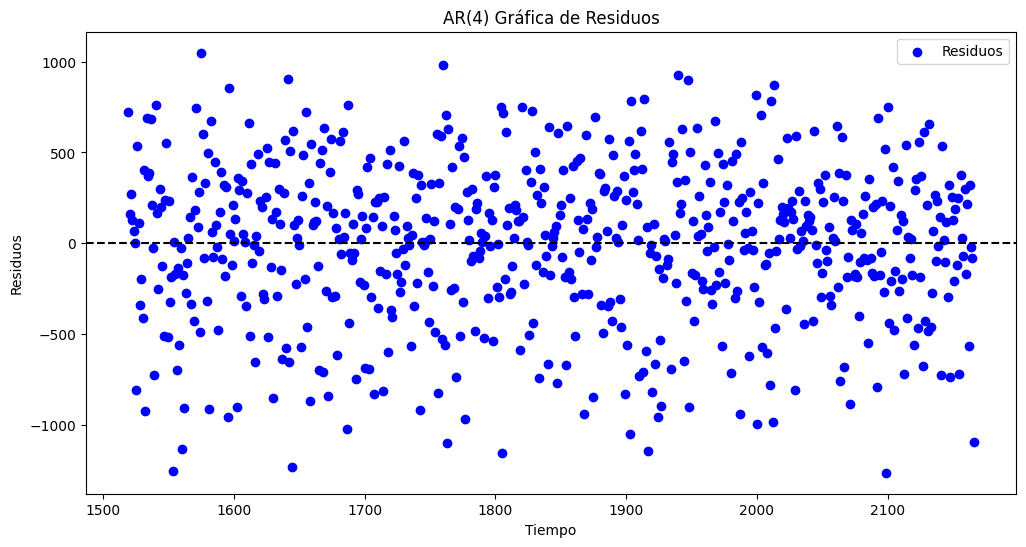

In [16]:
for lag in range(1, 5):
    X_lag = X.iloc[:, :lag]
    X_lag_train = X_train.iloc[:, :lag]
    X_lag_test = X_test.iloc[:, :lag]
    
    model = LinearRegression()
    model.fit(X_lag_train, y_train)
    models[f'AR({lag})'] = model
    
    predictions = model.predict(X_lag_test)
    residuals = y_test - predictions
    
    # Gráfica de residuos
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test.index, residuals, color='blue', label='Residuos')
    plt.axhline(y=0, color='black', linestyle='--')
    
    plt.title(f"AR({lag}) Gráfica de Residuos")
    plt.xlabel('Tiempo')
    plt.ylabel('Residuos')
    plt.legend()
    plt.show()


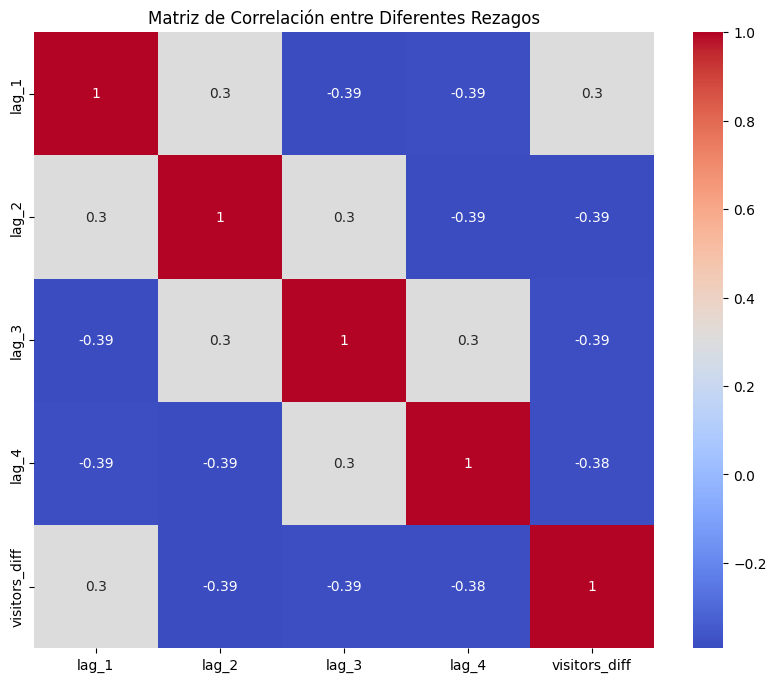

In [20]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(df[[f'lag_{i}' for i in range(1, 5)] + ['visitors_diff']].corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación entre Diferentes Rezagos")
plt.show()


<Figure size 1200x600 with 0 Axes>

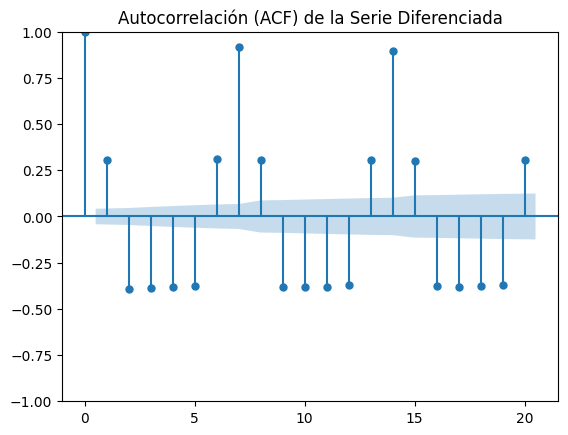

<Figure size 1200x600 with 0 Axes>

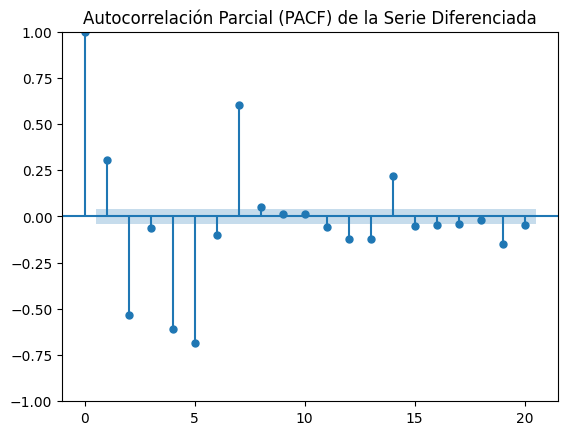

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(df['visitors_diff'].dropna(), lags=20)
plt.title("Autocorrelación (ACF) de la Serie Diferenciada")
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['visitors_diff'].dropna(), lags=20)
plt.title("Autocorrelación Parcial (PACF) de la Serie Diferenciada")
plt.show()


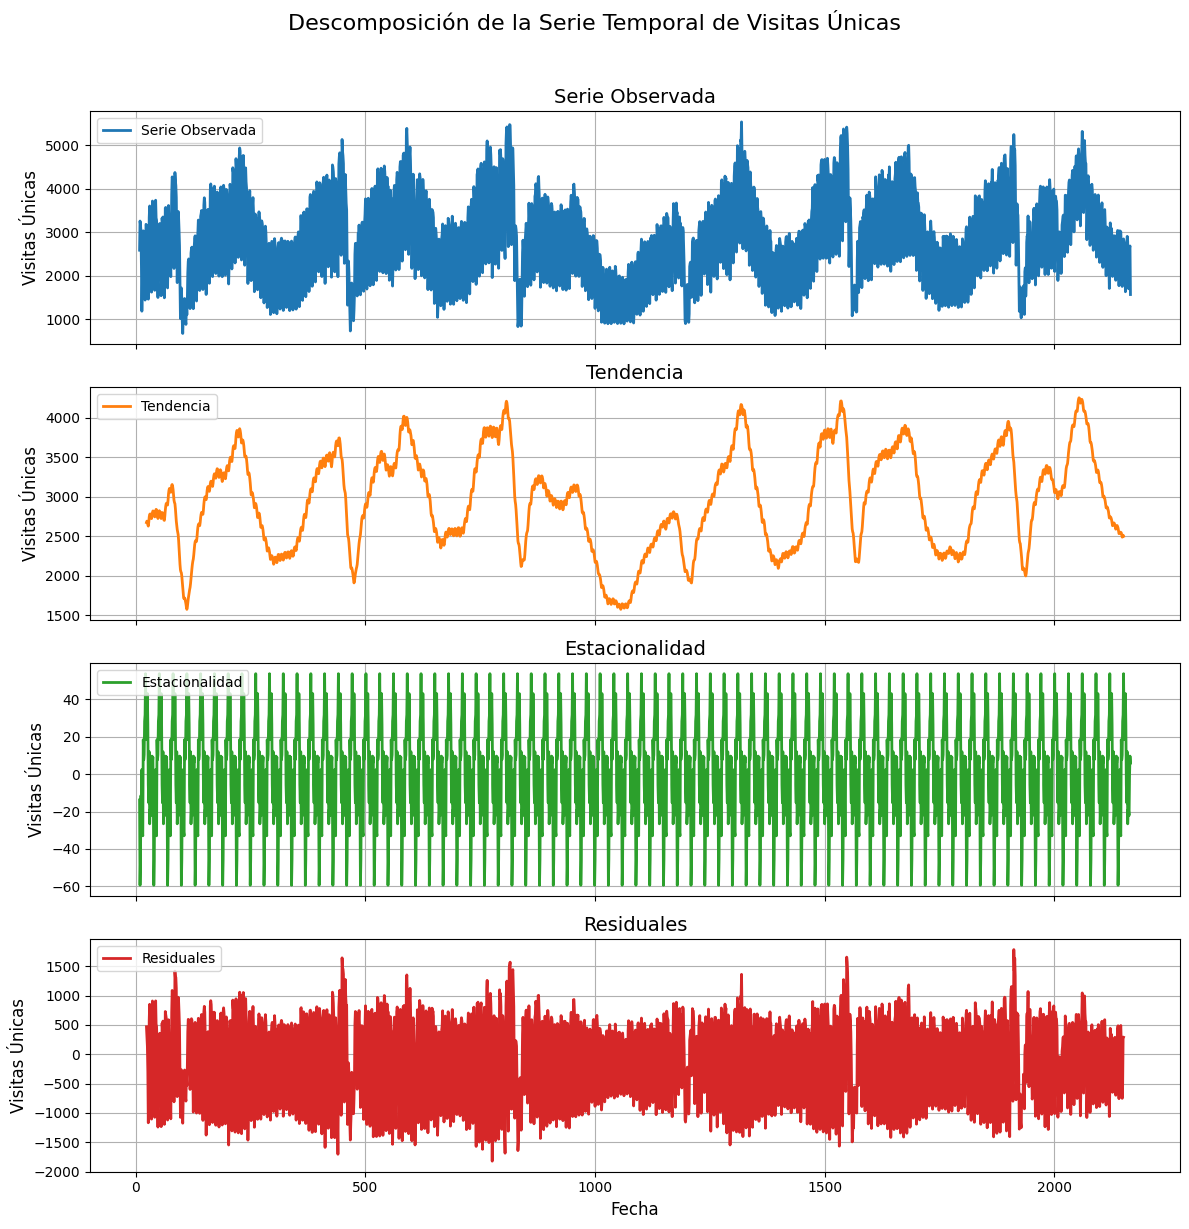

In [22]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de la serie temporal
decomposition = seasonal_decompose(df['Unique.Visits'], model='additive', period=30)

# Crear el gráfico
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Personalizar cada componente de la descomposición
components = ['observed', 'trend', 'seasonal', 'resid']
titles = ['Serie Observada', 'Tendencia', 'Estacionalidad', 'Residuales']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for ax, component, title, color in zip(axes, components, titles, colors):
    ax.plot(getattr(decomposition, component), color=color, linewidth=2)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Visitas Únicas', fontsize=12)
    ax.grid(True)
    ax.legend([title], loc='upper left')

plt.xlabel('Fecha', fontsize=12)
plt.suptitle("Descomposición de la Serie Temporal de Visitas Únicas", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
